In [698]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os
import numpy
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(3)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
tc= sns.color_palette('colorblind')
init_color= tc[4]
constraint_color= tc[1]
final_color= tc[3]
save_figures= False

Populating the interactive namespace from numpy and matplotlib


# Harmonic-oscillator M2M

## Mock observations

We sample from a distribution $f(z,v_z) \propto e^{-E/\sigma^2}$ with $\sigma = 0.1$. The gravitational potential is $\Phi(z) = \omega^2 z^2 / 2$, with $\omega = 1.3$. Sampling from $f(z,v_z)$ can be simply done by sampling $E \leftarrow e^{-E/\sigma^2}$ and $\phi \leftarrow \mathrm{Uniform(0,2\pi)}$ and then computing $z = \sqrt{2E}/\omega\,\cos\phi,\ v_z = -\sqrt{2E}\, \sin(\phi)$.

In [2]:
n_mock= 100000
sigma_true= 0.1
omega_true= 1.3
z_mock, vz_mock= hom2m.sample_iso(sigma_true,omega_true,n=n_mock)

The density distribution is Gaussian as expected:

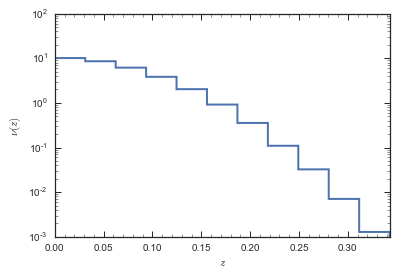

In [3]:
_= bovy_plot.bovy_hist(numpy.fabs(z_mock),bins=11,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0.05$:

In [4]:
zsun_true= 0.05
# We only observe the density at a few z
z_obs= numpy.array([0.1,0.15,0.2,-0.1,-0.15,-0.2])
h_obs= 0.025
# if w is None, compute_dense set w=1.0/n_mock which provides normalisation
dens_obs= hom2m.compute_dens(z_mock,zsun_true,z_obs,h_obs)
dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

The observed density is:

<Container object of 3 artists>

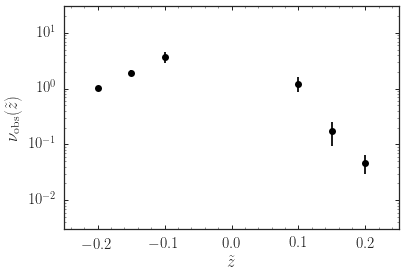

In [5]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.])
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean of the squared velocity:

In [54]:
# We only observe the v2 at a few z (same as before)
v2_obs= hom2m.compute_v2(z_mock,vz_mock,zsun_true,z_obs,h_obs)
#v2_obs_noise= numpy.sqrt(v2_obs)*0.2*numpy.sqrt(numpy.amax(v2_obs))\
#    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
# use constant noise
v2_obs_noise=numpy.zeros_like(v2_obs)+0.002
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v2_obs+= numpy.random.normal(size=v2_obs.shape)*v2_obs_noise
# v2_obs= sigma_true**2+numpy.random.normal(size=len(z_obs))*v2_obs_noise

<Container object of 3 artists>

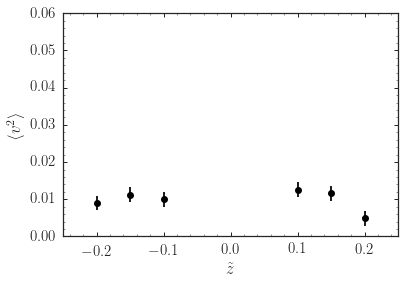

In [55]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0,0.06],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

###### Basic M2M fit

Here we perform the basic M2M fit to the observed density and the mean-squared velocity, assuming we know the potential. The initial density profile (blue line) is very different from the target:

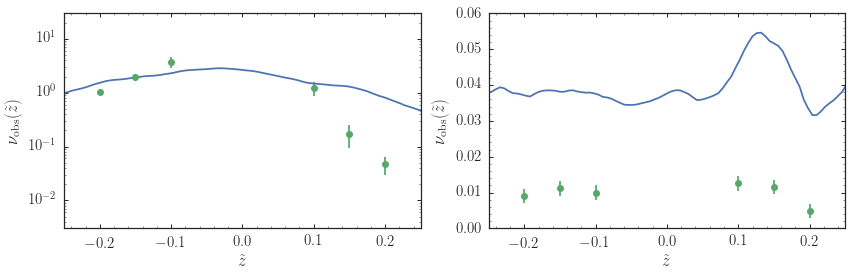

In [56]:
n_m2m= 1000
sigma_init= 0.2
h_m2m= 0.05
z_m2m, vz_m2m= hom2m.sample_iso(sigma_init,omega_true,n=n_m2m)
w_init= numpy.ones(n_m2m)/float(n_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.0,0.06])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
#yscale('log',nonposy='clip')
tight_layout()

Run without any smoothing:

In [57]:
reload(hom2m)

<module 'hom2m' from 'hom2m.py'>

In [58]:
step= numpy.pi/3.*10.**-2.
nstep= 100000
eps= 10.**-3.5
smooth= None#1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.075
omega_m2m= omega_true
zsun_m2m= zsun_true
prior= 'entropy'
use_v2=True
w_out,Q,wevol,windx= hom2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                                   z_obs,dens_obs,dens_obs_noise,
                                   v2_obs,v2_obs_noise,use_v2=use_v2,
                                   nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                                   smooth=smooth,st96smooth=st96smooth,output_wevolution=10)

In [59]:
numpy.sum(w_out)

0.92778361616821658

('Velocity dispersions: mock, fit', 0.099928616243094737, 0.099373598996505844)


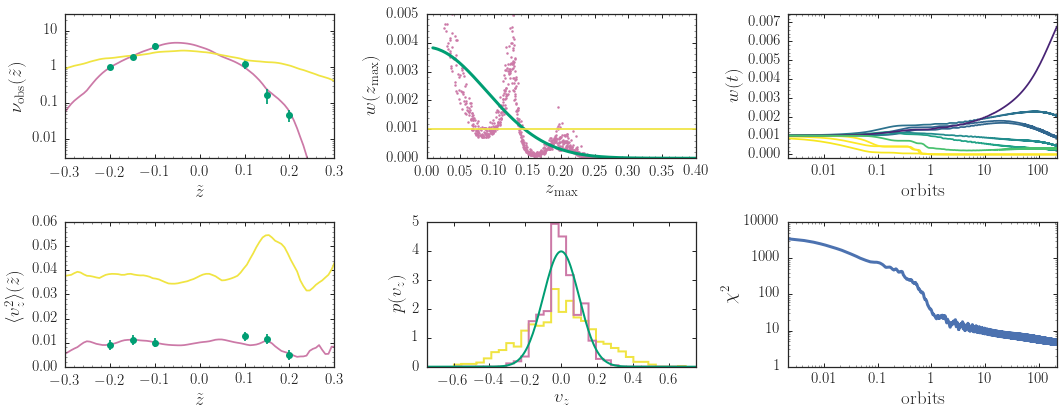

In [62]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.35,0.35,101)
dens_final= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.3,0.3],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[-.3,0.3],yrange=[0.0,0.06],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5./len(w_out)],xrange=[0.,0.4],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)
plot(A_m2m[sindx],w_expect,lw=3.,color=constraint_color)
axhline(1./len(z_m2m),color=init_color,)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(-0.75,0.75,201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-0.75,0.75)
ylim(0.,5.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

We can also look at how the fit converges (this is a movie):

In [63]:
step= numpy.pi/3.*10.**-2.
nstep= 100000
eps= 10.**-3.5
smooth= None#1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.075
omega_m2m= omega_true
zsun_m2m= zsun_true
prior= 'entropy'
use_v2=True
w_out,Q,wevol,windx= hom2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                                   z_obs,dens_obs,dens_obs_noise,
                                   v2_obs,v2_obs_noise,use_v2=use_v2,
                                   nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                                   smooth=smooth,st96smooth=st96smooth,
                                   output_wevolution=len(w_init))

In [64]:
figsize(12,4)
fig, (ax1, ax2) = pyplot.subplots(1,2)
subplot(1,2,1)
line1, = pyplot.plot([],[],lw=2)
subplot(1,2,2)
line2, = pyplot.plot([],[],lw=2)
line= [line1,line2]
subplots_adjust(wspace=.25)
def init_anim_frame():
    subplot(1,2,1)
    line1= bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                       xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                       xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
    line2= bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
    line3= errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
    subplot(1,2,2)
    line4= bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                       xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle$',
                       xrange=[-.25,0.25],yrange=[0.0,0.06],gcf=True)
    line5= bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)
    line6= errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
    return (line1[0],line2[0],line3[0],line4[0],line5[0],line6[0])
subsamp= 100
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
def animate(ii):
    tz_m2m= A_m2m*numpy.cos(phi_m2m+ii*subsamp*step*omega_m2m)
    tvz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+ii*subsamp*step*omega_m2m)
    dens_final= hom2m.compute_dens(tz_m2m[windx],zsun_true,z_out,h_m2m,w=wevol[:,ii*subsamp])
    line[0].set_data(z_out,dens_final)
    line[0].set_color(color=final_color)
    v2_final= hom2m.compute_v2(tz_m2m[windx],tvz_m2m[windx],zsun_true,z_out,h_m2m,w=wevol[:,ii*subsamp])
    line[1].set_data(z_out,v2_final)
    line[1].set_color(color=final_color)
    return line
anim = animation.FuncAnimation(fig,animate,init_func=init_anim_frame,
                               frames=nstep/subsamp,interval=40,blit=True,repeat=False)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

Now let's also include the uncertainty on the weights, by sampling from their (approximate) PDF:

In [69]:
reload(hom2m)

<module 'hom2m' from 'hom2m.pyc'>

In [70]:
savefilename= 'basic_data.sav' 
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
    w_out,z_m2m,vz_m2m,omega_m2m,zsun_m2m,z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise,w_init= out
else:
    save_pickles(savefilename,w_out,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                 z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise,w_init)

In [73]:
step_sam= numpy.pi/3.*10.**-2.
nstep_sam= nstep
eps_sam= eps
#nsamples= 100
# s_low, s_high= 16, -16
nsamples= 6
s_low, s_high=1,4
use_v2=True
savefilename= 'basic_sam.sav'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
else:
    out= hom2m.sample_m2m(nsamples,w_out,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                          z_obs,dens_obs,dens_obs_noise,
                          densv2_obs=v2_obs,densv2_obs_noise=v2_obs_noise,use_v2=use_v2,
                          nstep=nstep_sam,step=step_sam,eps=eps_sam,
                          mu=mu,h_m2m=h_m2m,prior=prior,w_prior=w_init,
                          smooth=smooth,st96smooth=st96smooth)
    save_pickles(savefilename,*out)
w_sam,Q_sam,z_sam,vz_sam= out


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [10:53<00:00, 107.80s/it]


 len zout, zsam[ii]= 0 101 1000
 len zout, zsam[ii]= 1 101 1000
 len zout, zsam[ii]= 2 101 1000
 len zout, zsam[ii]= 3 101 1000
 len zout, zsam[ii]= 4 101 1000
 len zout, zsam[ii]= 5 101 1000
('Velocity dispersions: mock, fit, mean of samples (unc.)', 0.099928616243094737, 0.098301282491134276, 0.09664528401309147, 0.00525690105823713)


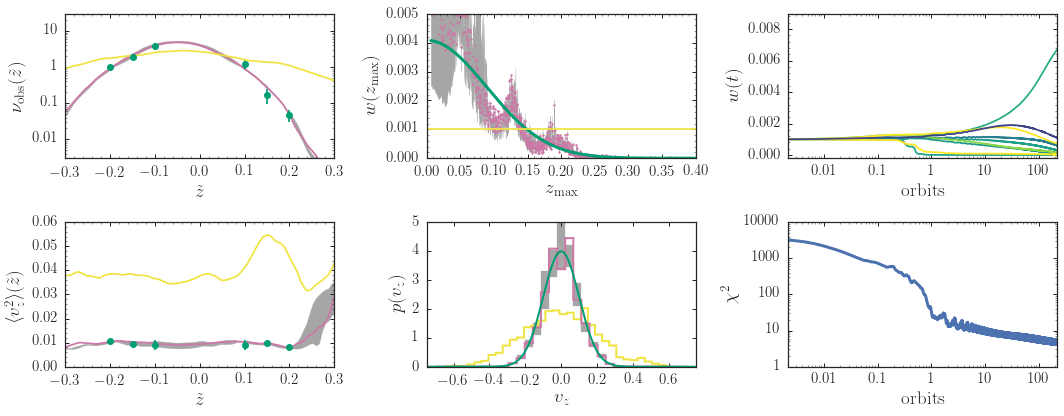

In [74]:
A_m2m_sam, _= hom2m.zvz_to_Aphi(z_sam[0],vz_sam[0],omega_m2m) # Make sure to lign up A_m2m and sampling orbits
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.35,0.35,101)
dens_final= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
# density and densv2 for samples
dens_final_sam= numpy.empty((nsamples,len(dens_final)))
v2_final_sam= numpy.empty((nsamples,len(dens_final)))
vz_hist= numpy.empty((nsamples,31))
sigvz= numpy.empty((nsamples))
for ii in range(nsamples):
    dens_final_sam[ii]= hom2m.compute_dens(z_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    v2_final_sam[ii]= hom2m.compute_v2(z_sam[ii],vz_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    vz_hist[ii], _= numpy.histogram(vz_sam[ii],weights=w_sam[ii],normed=True,bins=31,range=[-0.7,0.7])
    sigvz[ii]= numpy.sqrt(numpy.sum(w_sam[ii]*(vz_sam[ii]\
                            -numpy.sum(w_sam[ii]*vz_sam[ii])/numpy.sum(w_sam[ii]))**2.)/numpy.sum(w_sam[ii]))
dens_final_sam_sorted= numpy.sort(dens_final_sam,axis=0)
v2_final_sam_sorted= numpy.sort(v2_final_sam,axis=0)
w_sam_sorted= numpy.sort(w_sam,axis=0)
vz_hist_sorted= numpy.sort(vz_hist,axis=0)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.3,0.3],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
fill_between(z_out,dens_final_sam_sorted[s_low],dens_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[-.3,0.3],yrange=[0.0,0.06],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
fill_between(z_out,v2_final_sam_sorted[s_low],v2_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
#yscale(nonposy='clip')
#gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-y,0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5./len(w_out)],xrange=[0.,0.4],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)
plot(A_m2m[sindx],w_expect,lw=3.,color=constraint_color)
sindx= numpy.argsort(A_m2m_sam)
fill_between(A_m2m_sam[sindx],
             w_sam_sorted[s_low][sindx],
             w_sam_sorted[s_high][sindx],color='0.65',zorder=0)
axhline(1./len(z_m2m),color=init_color,)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(-0.75,0.75,201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
h,e,p= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color,range=[-0.7,0.7])
fill_between(0.5*(e+numpy.roll(e,1))[1:],vz_hist_sorted[s_low],vz_hist_sorted[s_high],color='0.65',zorder=0,step='mid')
xlim(-0.75,0.75)
ylim(0.,5.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit, mean of samples (unc.)",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)),
      numpy.mean(sigvz),
     numpy.std(sigvz))
subplot(2,3,3)
# only plot first 10
for ii in range(len(wevol[0:9])):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-hom2m','basic_m2m.pdf'),
                bbox_inches='tight')

A few individual samples:

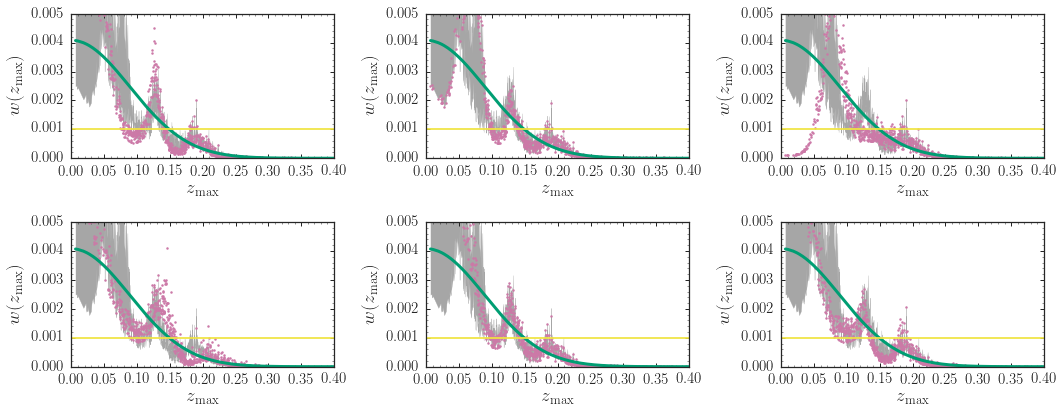

In [75]:
figsize(15,6)
for ii,jj in enumerate(numpy.random.permutation(nsamples)[:6]):
    subplot(2,3,ii+1)
    bovy_plot.bovy_plot(A_m2m_sam,w_sam[jj],'k.',ms=5.,color=final_color,
                        xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                       yrange=[0.,5./len(w_out)],xrange=[0.,0.4],gcf=True)
    sindx= numpy.argsort(A_m2m)
    plot(A_m2m[sindx],w_expect,lw=3.,color=constraint_color)
    sindx= numpy.argsort(A_m2m_sam)
    fill_between(A_m2m_sam[sindx],
             w_sam_sorted[s_low][sindx],
             w_sam_sorted[s_high][sindx],color='0.65',zorder=0)
    axhline(1./len(z_m2m),color=init_color)
tight_layout()

## Comparison to Schwarzschild modeling

To get a sense of how different orbits (parameterized by $z_{\mathrm{max}}$) contribute to the observables, we can orbit-average the kernels. We will color-code different observables using the standard seaborn color scheme for $z_{\mathrm{obs}} = 0.10, 0.15, 0.20, -0.10, -0.15, -0.20$:

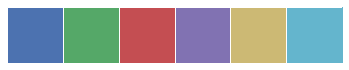

In [90]:
Image("color_palettes_8_0.png")

In [99]:
reload(hom2m)

<module 'hom2m' from 'hom2m.py'>

In [100]:
step= numpy.pi/3.*10.**-2.
nstep= 100000
omega_m2m= omega_true
zsun_m2m= zsun_true
use_v2=True
Kij, Kvz2ij= hom2m.precalc_kernel(z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                                  z_obs,use_v2=use_v2,nstep=nstep,step=step,h_m2m=h_m2m)

 size = (6, 1000) (1000,) (6,)


The orbit-averaged kernels for the density observable look like this (the first and last---the two blue---kernels are exactly the same because of the chosen value of $z_{\odot}$):

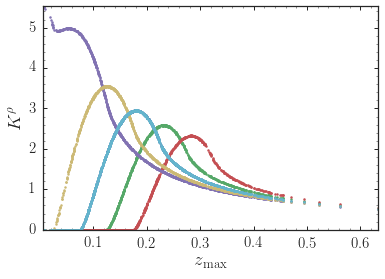

In [101]:
figsize(6,4)
_= bovy_plot.bovy_plot(A_m2m,Kij.T,'.',ms=5.,
                    xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$K^\rho$')

and for the velocity observables:

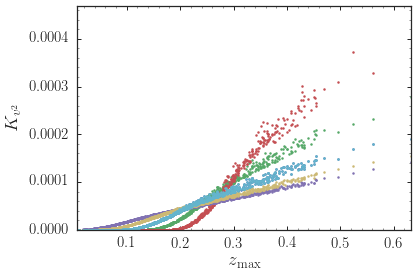

In [102]:
figsize(6,4)
_= bovy_plot.bovy_plot(A_m2m,Kvz2ij.T,'.',ms=5.,
                    xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$K_{v^2}$')

Thus, highly energetic orbits are strongly constrained by the velocity, because they would contribute high velocities in the observed volume). Low-energy orbits are mostly constrained by the density.

## Also fitting for $z_{\odot}$

In [105]:
reload(hom2m)

<module 'hom2m' from 'hom2m.py'>

In [106]:
step= numpy.pi/3.*10.**-2.
nstep= 100000
eps= [10.**-3.5,10.**-6.]
smooth= None#1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.075
omega_m2m= omega_true
zsun_m2m= zsun_true-0.1
fit_zsun= True
prior= 'entropy'
use_v2=True
w_out,zsun_out,Q,wevol,windx= hom2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                                            z_obs,dens_obs,dens_obs_noise,
                                            v2_obs,v2_obs_noise,use_v2=use_v2,
                                            nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                                            smooth=smooth,st96smooth=st96smooth,output_wevolution=10,
                                            fit_zsun=fit_zsun)

In [107]:
print(zsun_m2m,zsun_out[-1])

(-0.05, 0.055847690430131498)


('Velocity dispersions: mock, fit', 0.099928616243094737, 0.098059888009931859)


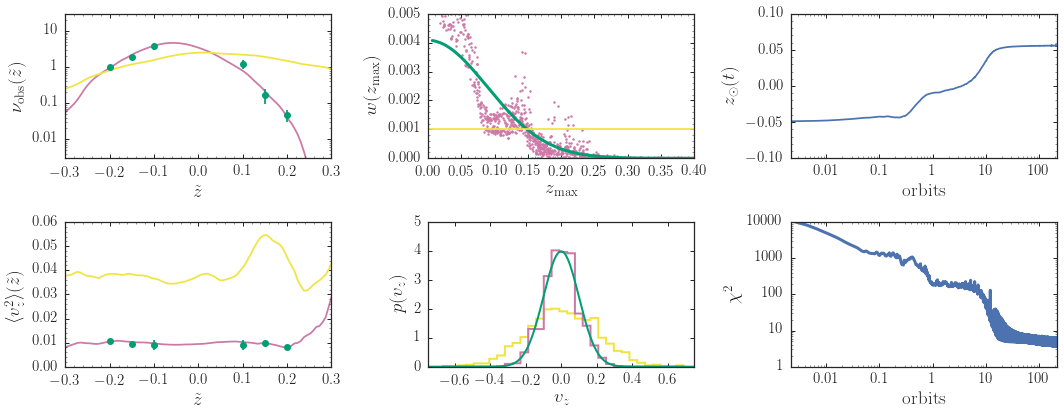

In [108]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.35,0.35,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
dens_final= hom2m.compute_dens(z_m2m,zsun_out[-1],z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_out[-1],z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.3,0.3],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[-.3,0.3],yrange=[0.0,.06],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                 lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5./len(w_out)],xrange=[0.,0.4],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)
plot(A_m2m[sindx],w_expect,lw=3.,color=constraint_color)
axhline(1./len(z_m2m),color=init_color,)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(-0.75,0.75,201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-0.75,0.75)
ylim(0.,5.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,zsun_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[-0.1,0.1],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot(t)$',gcf=True)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

Now let's also include the uncertainty on the weights and $z_\odot$, by sampling from their (approximate) PDF:

In [109]:
reload(hom2m)

<module 'hom2m' from 'hom2m.pyc'>

In [110]:
savefilename= 'zsun_data.sav' 
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
    w_out,z_m2m,vz_m2m,omega_m2m,zsun_out,z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise,w_init= out
else:
    save_pickles(savefilename,w_out,z_m2m,vz_m2m,omega_m2m,zsun_out,
                 z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise,w_init)

In [112]:
step_sam= numpy.pi/3.*10.**-2.
nstep_sam= nstep
eps_sam= eps
# nsamples= 100
nsamples= 6
fit_zsun= True
use_v2=True
sig_zsun= 0.01 # proposal step
# s_low, s_high= 16,-16
s_low, s_high= 1,4
savefilename= 'zsun_sam.sav'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
else:
    out= hom2m.sample_m2m(nsamples,w_out,z_m2m,vz_m2m,omega_m2m,zsun_out[-1],
                          z_obs,dens_obs,dens_obs_noise,
                          densv2_obs=v2_obs,densv2_obs_noise=v2_obs_noise,
                          use_v2=use_v2,nstep=nstep_sam,step=step_sam,eps=eps_sam,
                          mu=mu,h_m2m=h_m2m,prior=prior,w_prior=w_init,
                          smooth=smooth,st96smooth=st96smooth,
                          fit_zsun=fit_zsun,sig_zsun=sig_zsun)
    save_pickles(savefilename,*out)
w_sam,zsun_sam,Q_sam,z_sam,vz_sam= out

100%|██████████| 6/6 [12:02<00:00, 120.40s/it]

MH acceptance ratio for zsun was 0.32


How does the convergence look:

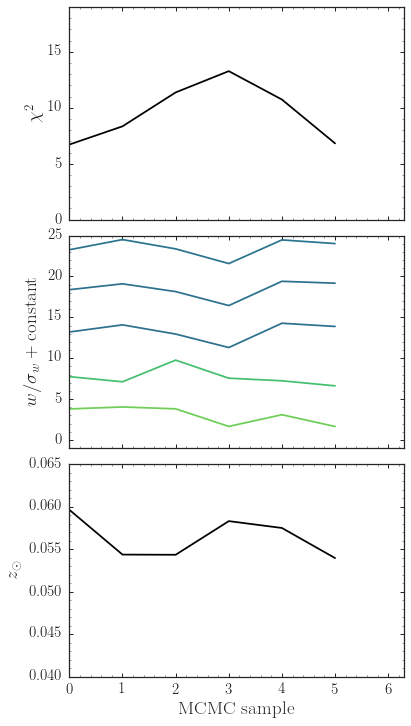

In [113]:
A_m2m_sam, _= hom2m.zvz_to_Aphi(z_sam[0],vz_sam[0],omega_m2m) # Make sure to lign up A_m2m and sampling orbits
figsize(6,12)
gs= gridspec.GridSpec(3,1,hspace=0.075,wspace=0.0)
subplot(gs[0])
bovy_plot.bovy_plot(numpy.sum(Q_sam,axis=1),gcf=True,color='k',
                   ylabel=r'$\chi^2$',
                   xrange=[0.,nsamples*1.05],
                   yrange=[0.,19.])
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs[1])
nran= 5
rndindx= numpy.random.permutation(len(w_sam[0]))[:nran-1]
# Add a weight near in A_m2m to the weight with the 2nd largest A_m2m
medA= A_m2m_sam[rndindx][numpy.argsort(A_m2m_sam[rndindx])[-3]]
newi= numpy.argmin(numpy.fabs(A_m2m_sam-medA+0.005))
rndindx= list(rndindx)
rndindx.append(newi)
rndindx= numpy.array(rndindx,dtype='int')
sindx= numpy.argsort(numpy.argsort(numpy.mean(w_sam[:,rndindx],axis=0)))
for ii,jj in enumerate(rndindx):
    bovy_plot.bovy_plot(w_sam[:,jj]/numpy.std(w_sam[:,jj])+5*sindx[ii],'-',
                        color=cm.viridis(A_m2m_sam[jj]/0.3),
                        xrange=[0.,nsamples*1.05],
                        yrange=[-1,25],
                        ylabel=r'$w/\sigma_w+\mathrm{constant}$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs[2])
bovy_plot.bovy_plot(zsun_sam,gcf=True,color='k',
                    xlabel=r'$\mathrm{MCMC\ sample}$',
                    ylabel=r'$z_\odot$',
                    xrange=[0.,nsamples*1.05],
                    yrange=[0.04,0.065])
if save_figures: # Save example with (a) a weight near zero and (b) two weights with similar A_m2m that are correlated
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-hom2m','zsun_mcmc.pdf'),
                bbox_inches='tight')

Looks like a good chain. Now the summary plot:

('Velocity dispersions: mock, fit, mean of samples (unc.)', 0.099928616243094737, 0.097868725986666696, 0.098736273539175037, 0.0042115943356532664)
('zsun: best-fit, mean of samples unc.)', 0.055847690430131498, 0.056343417268928858, 0.0022206324340485629)


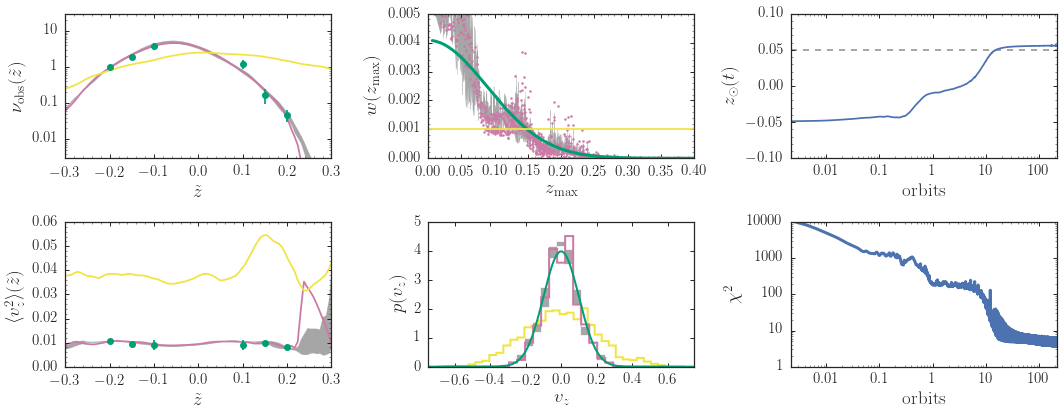

In [116]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.35,0.35,101)
dens_final= hom2m.compute_dens(z_m2m,zsun_out[-1],z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_out[-1],z_out,h_m2m,w=w_out)
# density and v2 for samples
dens_final_sam= numpy.empty((nsamples,len(dens_final)))
v2_final_sam= numpy.empty((nsamples,len(dens_final)))
vz_hist= numpy.empty((nsamples,31))
sigvz= numpy.empty((nsamples))
for ii in range(nsamples):
    dens_final_sam[ii]= hom2m.compute_dens(z_sam[ii],zsun_sam[ii],z_out,h_m2m,w=w_sam[ii])
    v2_final_sam[ii]= hom2m.compute_v2(z_sam[ii],vz_sam[ii],zsun_sam[ii],z_out,h_m2m,w=w_sam[ii])
    vz_hist[ii], _= numpy.histogram(vz_sam[ii],weights=w_sam[ii],normed=True,bins=31,range=[-0.7,0.7])
    sigvz[ii]= numpy.sqrt(numpy.sum(w_sam[ii]*(vz_sam[ii]\
                            -numpy.sum(w_sam[ii]*vz_sam[ii])/numpy.sum(w_sam[ii]))**2.)/numpy.sum(w_sam[ii]))
dens_final_sam_sorted= numpy.sort(dens_final_sam,axis=0)
v2_final_sam_sorted= numpy.sort(v2_final_sam,axis=0)
w_sam_sorted= numpy.sort(w_sam,axis=0)
vz_hist_sorted= numpy.sort(vz_hist,axis=0)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.3,0.3],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
fill_between(z_out,dens_final_sam_sorted[s_low],dens_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[-.3,0.3],yrange=[0.0,.06],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
fill_between(z_out,v2_final_sam_sorted[s_low],v2_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5./len(w_out)],xrange=[0.,0.4],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)
plot(A_m2m[sindx],w_expect,lw=3.,color=constraint_color)
sindx= numpy.argsort(A_m2m_sam) # might have changed due to pickling
fill_between(A_m2m_sam[sindx],
             w_sam_sorted[s_low][sindx],
             w_sam_sorted[s_high][sindx],color='0.65',zorder=0)
axhline(1./len(z_m2m),color=init_color,)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(-0.75,0.75,201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
h,e,p= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color,range=[-0.7,0.7])
fill_between(0.5*(e+numpy.roll(e,1))[1:],vz_hist_sorted[s_low],vz_hist_sorted[s_high],color='0.65',zorder=0,step='mid')
xlim(-0.75,0.75)
ylim(0.,5.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit, mean of samples (unc.)",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)),
      numpy.mean(sigvz),
     numpy.std(sigvz))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,zsun_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[-0.1,0.1],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot(t)$',gcf=True)
axhline(zsun_true,ls='--',color='0.65',lw=2.,zorder=0)
print("zsun: best-fit, mean of samples unc.)",zsun_out[-1],numpy.mean(zsun_sam),numpy.std(zsun_sam))
"""
min_zsun, max_zsun= numpy.amin(zsun_sam), numpy.amax(zsun_sam)
for ii in range(nsamples):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,len(zsun_sam[0]))*len(zsun_sam[0])*step*omega_true/2./numpy.pi,
                        zsun_sam[ii],'-',
                        color=cm.viridis((zsun_sam[ii]-min_zsun)/(max_zsun-min_zsun)),overplot=True)
"""
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-hom2m','zsun_m2m.pdf'),
                bbox_inches='tight')

The distribution of $z_\odot$ is

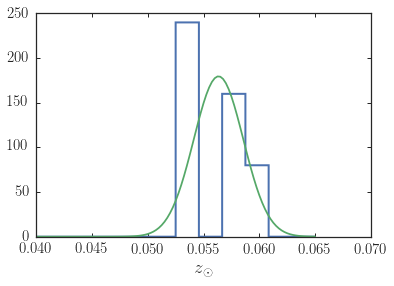

In [117]:
figsize(6,4)
_= hist(zsun_sam,range=[0.04,0.065],bins=12,histtype='step',lw=2.,normed=True)
xlabel(r'$z_\odot$')
mzsun, szsun= numpy.mean(zsun_sam), numpy.std(zsun_sam)
xs= numpy.linspace(0.04,0.065,101)
ys= numpy.exp(-0.5*(xs-mzsun)**2./szsun**2.)
ys/= numpy.sum(ys)*(xs[1]-xs[0])
plot(xs,ys)

A few example samples:

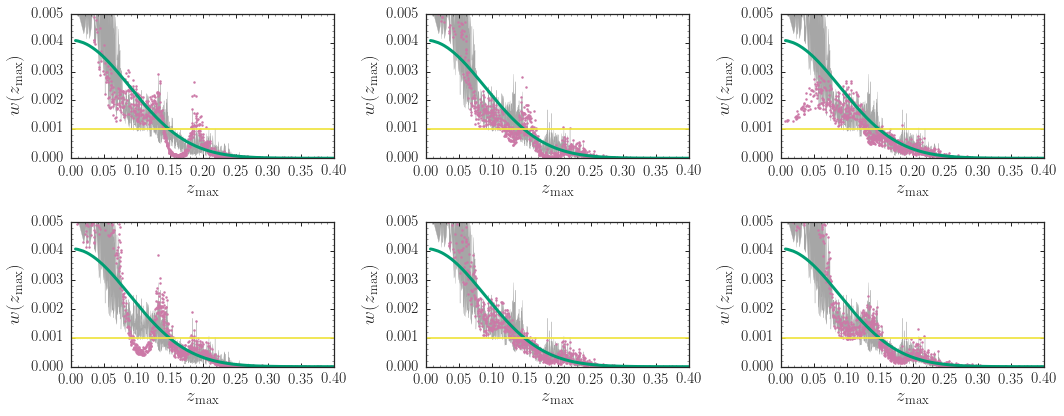

In [118]:
figsize(15,6)
for ii,jj in enumerate(numpy.random.permutation(nsamples)[:6]):
    subplot(2,3,ii+1)
    bovy_plot.bovy_plot(A_m2m_sam,w_sam[jj],'k.',ms=5.,color=final_color,
                        xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                       yrange=[0.,5./len(w_out)],xrange=[0.,0.4],gcf=True)
    sindx= numpy.argsort(A_m2m)
    plot(A_m2m[sindx],w_expect,lw=3.,color=constraint_color)
    sindx= numpy.argsort(A_m2m_sam)
    fill_between(A_m2m_sam[sindx],
             w_sam_sorted[s_low][sindx],
             w_sam_sorted[s_high][sindx],color='0.65',zorder=0)
    axhline(1./len(z_m2m),color=init_color)
tight_layout()

What's the answer when we fit a simple isothermal DF?

In [123]:
def lnL_df(p,z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise):
    """p=[zsun,sigma]"""
    return -0.5*numpy.sum((p[2]*numpy.exp(-0.5*(z_obs+p[0])**2.*omega_true**2./p[1]**2.)*omega_true/p[1]/numpy.sqrt(2.*numpy.pi)
                          -dens_obs)**2./dens_obs_noise**2.
                          +(p[1]**2-v2_obs)**2./v2_obs_noise**2.)
sigmas= numpy.linspace(0.05,0.16,101)
zsuns= numpy.linspace(0.0,0.1,101)
lnL= numpy.zeros((len(zsuns),len(sigmas)))
amps= numpy.linspace(0.5,2.,201)
lnL_amp= numpy.empty(len(amps))
for ii,zsun in enumerate(zsuns):
    for jj,sigma in enumerate(sigmas):
        for kk,amp in enumerate(amps):
            lnL_amp[kk]= lnL_df([zsun,sigma,amp],z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise)
        lnL[ii,jj]= logsumexp(lnL_amp)

Best fit: (zsun,sigma) = (0.050,0.098)
Mean: (zsun,sigma) = (0.0535,0.0977)
errors: (zsun,sigma) = (0.0088,0.0014)


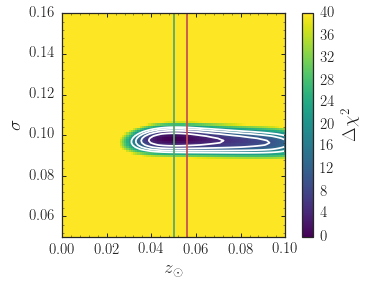

In [124]:
bovy_plot.bovy_dens2d(-2.*(lnL-numpy.amax(lnL)).T,origin='lower',
                      xrange=[zsuns[0],zsuns[-1]],
                      yrange=[sigmas[0],sigmas[-1]],
                      xlabel=r'$z_\odot$',ylabel=r'$\sigma$',
                      zlabel=r'$\Delta\chi^2$',
                      colorbar=True,cmap='viridis',vmax=40.,shrink=1.,
                      contours=True,levels=numpy.arange(5)*5.,cntrcolors='w',
                      interpolation='nearest')
axvline(zsun_true,color=sns.color_palette()[1])
axvline(zsun_out[-1],color=sns.color_palette()[2])
print("Best fit: (zsun,sigma) = (%.3f,%.3f)"\
          %(zsuns[numpy.unravel_index(numpy.argmax(lnL),(len(zsuns),len(sigmas)))[0]],
            sigmas[numpy.unravel_index(numpy.argmax(lnL),(len(zsuns),len(sigmas)))[1]]))
tp= numpy.exp(lnL)
tp/= numpy.sum(tp)
print("Mean: (zsun,sigma) = (%.4f,%.4f)"\
          %(numpy.sum(numpy.atleast_2d(zsuns).T*tp),
            numpy.sum(numpy.atleast_2d(sigmas)*tp)))
print("errors: (zsun,sigma) = (%.4f,%.4f)"\
          %(numpy.sqrt(numpy.sum(numpy.atleast_2d(zsuns).T**2.*tp)-numpy.sum(numpy.atleast_2d(zsuns).T*tp)**2.),
            numpy.sqrt(numpy.sum(numpy.atleast_2d(sigmas)**2.*tp)-numpy.sum(numpy.atleast_2d(sigmas)*tp)**2.)))

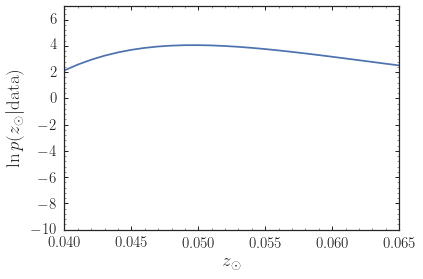

In [125]:
figsize(6,4)
ys= numpy.sum(numpy.exp(lnL),axis=1)
ys/= numpy.sum(ys)*(zsuns[1]-zsuns[0])
bovy_plot.bovy_plot(zsuns,numpy.log(ys),
                    xrange=[0.04,0.065],
                    yrange=[-10.,7.],
                   xlabel=r'$z_\odot$',
                   ylabel=r'$\ln p(z_\odot|\mathrm{data})$')

What if we followed the standard procedure and computed the best-fit weights distribution for each $z_\odot$? This is shown in blue and compared to the result from assuming an isothermal DF above (green). The best-fit M2M value is in red.

In [126]:
zsuns_opt= numpy.linspace(0.04,0.065,11)
nstep_opt= nstep
Qs= numpy.zeros_like(zsuns_opt)
use_v2=True
for ii,zsun_m2m in tqdm.tqdm(enumerate(zsuns_opt),total=len(zsuns_opt)):
    w_out,Q= hom2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                           z_obs,dens_obs,dens_obs_noise,
                           v2_obs,v2_obs_noise,use_v2=use_v2,
                           nstep=nstep_opt,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                           smooth=smooth,st96smooth=st96smooth)
    Qs[ii]= numpy.sum(numpy.median(Q[-100:-1],axis=0))

100%|██████████| 11/11 [19:54<00:00, 105.20s/it]


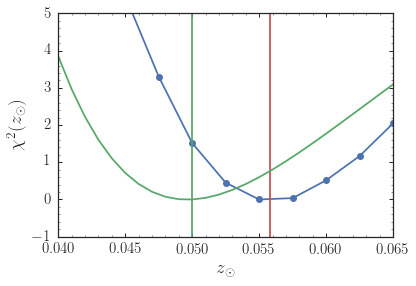

In [127]:
figsize(6,4)
bovy_plot.bovy_plot(zsuns_opt,Qs-numpy.nanmin(Qs),
                    'o-',semilogy=False,yrange=[-1.,5.],
                   xlabel=r'$z_\odot$',ylabel=r'$\chi^2(z_\odot)$')
axvline(zsun_true,color=sns.color_palette()[1])
axvline(zsun_out[-1],color=sns.color_palette()[2])
plot(zsuns,-2.*(numpy.log(ys)-numpy.nanmax(numpy.log(ys))))

We can also compare the histogram (blue) and Gaussian fit (green) of the $z_\odot$ samples to the PDF obtained by maximizing $\chi^2$ for a grid of $z_\odot$ values:

('Standard result: mean, unc.:', 0.056433350250097596, 0.0047730597046085621)


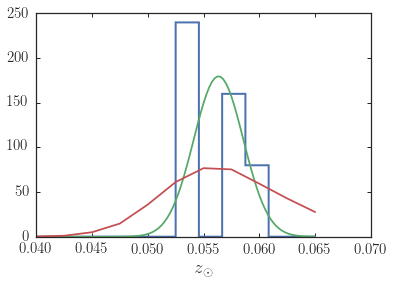

In [128]:
figsize(6,4)
_= hist(zsun_sam,range=[0.04,0.065],bins=12,histtype='step',lw=2.,normed=True)
xlabel(r'$z_\odot$')
mzsun, szsun= numpy.mean(zsun_sam), numpy.std(zsun_sam)
xs= numpy.linspace(0.04,0.065,101)
ys= numpy.exp(-0.5*(xs-mzsun)**2./szsun**2.)
ys/= numpy.sum(ys)*(xs[1]-xs[0])
plot(xs,ys)
# That from fitting on a grid of zsun
ys= numpy.exp(-Qs/2.)
ys/= numpy.sum(ys)*(zsuns_opt[1]-zsuns_opt[0])
plot(zsuns_opt,ys)
ys/= numpy.sum(ys)
print("Standard result: mean, unc.:",
      numpy.sum(zsuns_opt*ys),
      numpy.sqrt(numpy.sum(zsuns_opt**2.*ys)-numpy.sum(zsuns_opt*ys)**2.))

The two PDFs agree well.

## Also fitting for the potential parameter $\omega$

In [129]:
n_m2m= 1000
omega_m2m= omega_true-0.5
sigma_init= 0.2
E_m2m= numpy.random.exponential(scale=sigma_init**2.,size=n_m2m)
phi_m2m_omega= numpy.random.uniform(size=n_m2m)*2.*numpy.pi
A_m2m_omega= numpy.sqrt(2.*E_m2m)/omega_m2m
w_init= numpy.ones(n_m2m)/n_m2m
z_m2m= A_m2m_omega*numpy.cos(phi_m2m_omega)
vz_m2m= -omega_m2m*A_m2m_omega*numpy.sin(phi_m2m_omega)

In [144]:
reload(hom2m)

<module 'hom2m' from 'hom2m.py'>

In [147]:
step= numpy.pi/3.*10.**-2.
nstep= 100000
eps= [10.**-3.5,10.**-3.5]
smooth= None#1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.075
#omega_m2m= set in previous cell
zsun_m2m= zsun_true
fit_omega= True
# skipomega= 40
skipomega= 10
prior= 'entropy'
use_v2=True
w_out,omega_out,z_final, vz_final, Q,wevol,windx= hom2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                                                                z_obs,dens_obs,dens_obs_noise,
                                                                v2_obs,v2_obs_noise,use_v2=use_v2,
                                                                nstep=nstep,step=step,mu=mu,eps=eps,
                                                                h_m2m=h_m2m,prior=prior,
                                                                smooth=smooth,st96smooth=st96smooth,
                                                                output_wevolution=10,
                                                                fit_omega=fit_omega,skipomega=skipomega)

('Velocity dispersions: mock, fit', 0.099928616243094737, 0.099029137152760141)
('omega: best-fit', 1.3179800725286095)


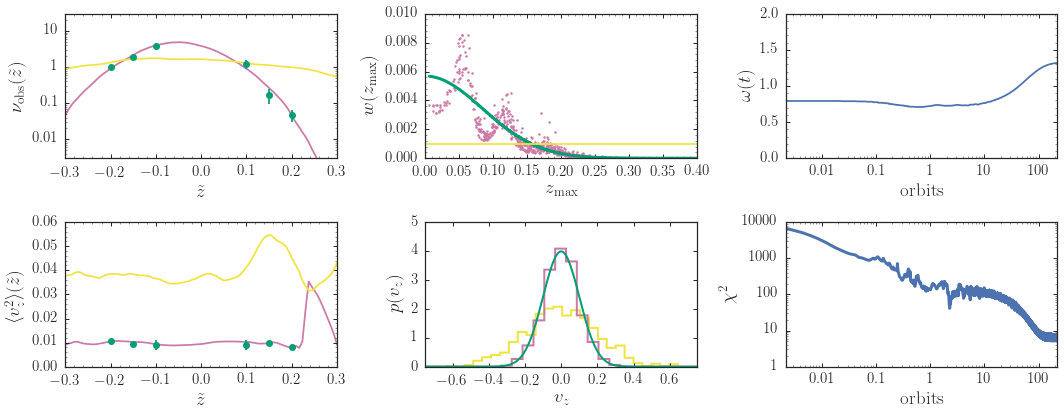

In [148]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_final,vz_final,omega_out[-1])
A_init, phi_init= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_out= numpy.linspace(-0.35,0.35,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
dens_final= hom2m.compute_dens(z_final,zsun_m2m,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_final,vz_final,zsun_m2m,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.3,0.3],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[-.3,0.3],yrange=[0.0,.06],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                 lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,10./len(w_out)],xrange=[0.,0.4],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_init[sindx]*omega_m2m)**2./2./sigma_init**2.-(A_m2m[sindx]*omega_true)**2./2./sigma_true**2.)
w_expect/= numpy.sum(w_expect)
plot(A_m2m[sindx],w_expect,lw=3.,color=constraint_color)
axhline(1./len(z_m2m),color=init_color,)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(-0.75,0.75,201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_final,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-0.75,0.75)
ylim(0.,5.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_final-numpy.sum(w_out*vz_final)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,2.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
print("omega: best-fit",omega_out[-1])
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [149]:
reload(hom2m)

<module 'hom2m' from 'hom2m.py'>

In [150]:
savefilename= 'omega_data.sav' 
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
    w_out,z_final,vz_final,omega_out,zsun_m2m,z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise= out
else:
    save_pickles(savefilename,w_out,z_final,vz_final,omega_out,zsun_m2m,
                 z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise)

In [153]:
step_sam= numpy.pi/3.*10.**-2.
nstep_sam= 100000
eps_sam= eps
# nsamples= 100
nsamples= 6
fit_omega= True
sig_omega= 0.2 # proposal step
nstep_omega= 1000
nmh_omega= 20
fit_zsun= False
sig_zsun= 0.01
# s_low, s_high= 16,-16
s_low, s_high=1,4
use_v2=True
savefilename= 'omega_sam.sav'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
else:
    out= hom2m.sample_m2m(nsamples,w_out,z_final,vz_final,omega_out[-1],zsun_m2m,
                          z_obs,dens_obs,dens_obs_noise,
                          densv2_obs=v2_obs,densv2_obs_noise=v2_obs_noise,use_v2=use_v2,
                          nstep=nstep_sam,step=step_sam,eps=eps_sam,
                          mu=mu,h_m2m=h_m2m,prior=prior,w_prior=w_init,
                          smooth=smooth,st96smooth=st96smooth,
                          fit_omega=fit_omega,sig_omega=sig_omega,nstep_omega=nstep_omega,nmh_omega=nmh_omega,
                          fit_zsun=fit_zsun,sig_zsun=sig_zsun)
    save_pickles(savefilename,*out)
w_sam,omega_sam,Q_sam,z_sam,vz_sam= out




  0%|          | 0/6 [00:00<?, ?it/s]




 17%|█▋        | 1/6 [02:27<12:17, 147.51s/it]


 33%|███▎      | 2/6 [04:54<09:49, 147.44s/it]


 50%|█████     | 3/6 [07:16<07:17, 145.73s/it]


 67%|██████▋   | 4/6 [09:39<04:50, 145.04s/it]


 83%|████████▎ | 5/6 [12:03<02:24, 144.62s/it]


100%|██████████| 6/6 [14:25<00:00, 143.93s/it]

MH acceptance ratio for omega was 0.22


In [154]:
omega_sam, numpy.mean(omega_sam), numpy.std(omega_sam)

(array([ 1.30717684,  1.37411965,  1.39990799,  1.34952592,  1.34295902,
         1.26813076]), 1.3403033649663705, 0.04300118667417939)

In [155]:
print(numpy.sum(Q_sam,axis=1))

[ 13.16886109  10.39197824  10.14877822   7.34745687  14.86973821
  10.25724203]


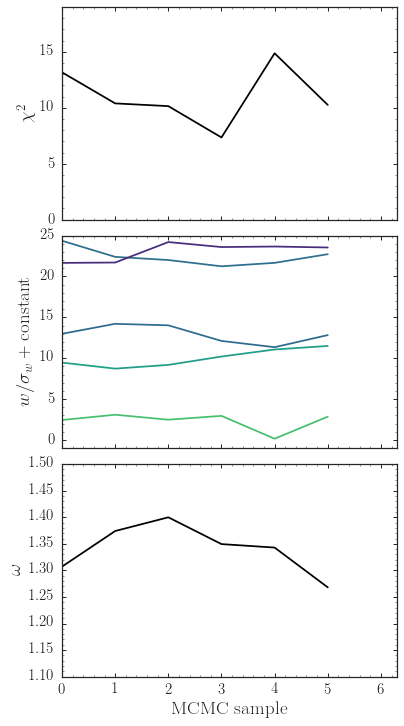

In [156]:
A_m2m_sam, _= hom2m.zvz_to_Aphi(z_sam[0],vz_sam[0],omega_sam[0]) # Make sure to lign up A_m2m and sampling orbits
figsize(6,12)
gs= gridspec.GridSpec(3,1,hspace=0.075,wspace=0.0)
subplot(gs[0])
bovy_plot.bovy_plot(numpy.sum(Q_sam,axis=1),gcf=True,color='k',
                   ylabel=r'$\chi^2$',
                   xrange=[0.,nsamples*1.05],
                   yrange=[0.,19.])
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs[1])
nran= 5
rndindx= numpy.random.permutation(len(w_sam[0]))[:nran-1]
# Add a weight near in A_m2m to the weight with the 2nd largest A_m2m
medA= A_m2m_sam[rndindx][numpy.argsort(A_m2m_sam[rndindx])[-3]]
newi= numpy.argmin(numpy.fabs(A_m2m_sam-medA+0.005))
rndindx= list(rndindx)
rndindx.append(newi)
rndindx= numpy.array(rndindx,dtype='int')
sindx= numpy.argsort(numpy.argsort(numpy.nanmean(w_sam[:,rndindx],axis=0)))
for ii,jj in enumerate(rndindx):
    bovy_plot.bovy_plot(w_sam[:,jj]/numpy.nanstd(w_sam[:,jj])+5*sindx[ii],'-',
                        color=cm.viridis(A_m2m_sam[jj]*numpy.sqrt(omega_out[0]/1.3)/0.3),
                        xrange=[0.,nsamples*1.05],
                        yrange=[-1,25],
                        ylabel=r'$w/\sigma_w+\mathrm{constant}$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs[2])
bovy_plot.bovy_plot(omega_sam,gcf=True,color='k',
                    xlabel=r'$\mathrm{MCMC\ sample}$',
                    ylabel=r'$\omega$',
                    xrange=[0.,nsamples*1.05],
                    yrange=[1.1,1.5])
if save_figures: # Save example with (a) a weight near zero and (b) two weights with similar A_m2m that are correlated
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-hom2m','omega_mcmc.pdf'),
                bbox_inches='tight')

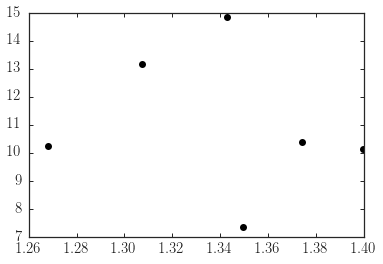

In [157]:
figsize(6,4)
plot(omega_sam,numpy.sum(Q_sam,axis=1),'ko')

Looks like a good chain. Now the summary plot:

('Velocity dispersions: mock, fit, mean of samples (unc.)', 0.099928616243094737, 0.099029137152760141, 0.098297797782291751, 0.0044183976130063932)
('omega: best-fit, mean of samples unc.)', 1.3179800725286095, 1.3403033649663705, 0.04300118667417939)


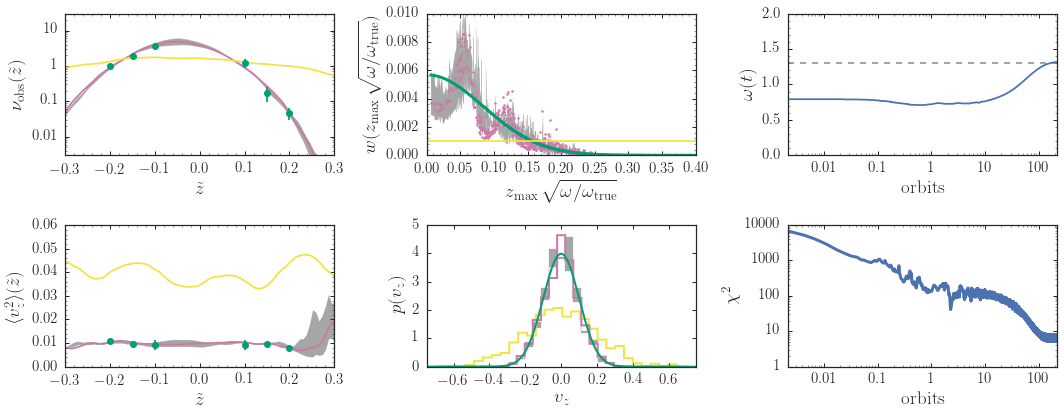

In [158]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_final,vz_final,omega_out[-1])
A_init, phi_init= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_out= numpy.linspace(-0.35,0.35,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
dens_final= hom2m.compute_dens(z_final,zsun_m2m,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_final,vz_final,zsun_m2m,z_out,h_m2m,w=w_out)
# density and densv2 for samples
dens_final_sam= numpy.empty((nsamples,len(dens_final)))
v2_final_sam= numpy.empty((nsamples,len(dens_final)))
vz_hist= numpy.empty((nsamples,31))
sigvz= numpy.empty((nsamples))
for ii in range(nsamples):
    dens_final_sam[ii]= hom2m.compute_dens(z_sam[ii],zsun_m2m,z_out,h_m2m,w=w_sam[ii])
    v2_final_sam[ii]= hom2m.compute_v2(z_sam[ii],vz_sam[ii],zsun_m2m,z_out,h_m2m,w=w_sam[ii])
    vz_hist[ii], _= numpy.histogram(vz_sam[ii],weights=w_sam[ii],normed=True,bins=31,range=[-0.7,0.7])
    sigvz[ii]= numpy.sqrt(numpy.sum(w_sam[ii]*(vz_sam[ii]\
                            -numpy.sum(w_sam[ii]*vz_sam[ii])/numpy.sum(w_sam[ii]))**2.)/numpy.sum(w_sam[ii]))
dens_final_sam_sorted= numpy.sort(dens_final_sam,axis=0)
v2_final_sam_sorted= numpy.sort(v2_final_sam,axis=0)
w_sam_sorted= numpy.sort(w_sam,axis=0)
vz_hist_sorted= numpy.sort(vz_hist,axis=0)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.3,0.3],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
fill_between(z_out,dens_final_sam_sorted[s_low],dens_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[-.3,0.3],yrange=[0.0,.06],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
fill_between(z_out,v2_final_sam_sorted[s_low],v2_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m*numpy.sqrt(omega_out[-1]/1.3),w_out,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}\,\sqrt{\omega/\omega_{\mathrm{true}}}$',
                    ylabel=r'$w(z_{\mathrm{max}}\,\sqrt{\omega/\omega_{\mathrm{true}}})$',
                   yrange=[0.,10./len(w_out)],xrange=[0.,0.4],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_init[sindx]*omega_m2m)**2./2./sigma_init**2.-(A_m2m[sindx]*omega_true)**2./2./sigma_true**2.)
w_expect/= numpy.sum(w_expect)
plot(A_m2m[sindx]*numpy.sqrt(omega_out[-1]/1.3),w_expect,lw=3.,color=constraint_color)
sindx= numpy.argsort(A_m2m_sam*numpy.sqrt(omega_sam[0])) # might have changed due to pickling
fill_between(A_m2m_sam[sindx]*numpy.sqrt(omega_sam[0]/1.3),
             w_sam_sorted[s_low][sindx],
             w_sam_sorted[s_high][sindx],color='0.65',zorder=0)
axhline(1./len(z_m2m),color=init_color,)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(-0.75,0.75,201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
h,e,p= hist(vz_final,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color,
            range=[-0.7,0.7])
fill_between(0.5*(e+numpy.roll(e,1))[1:],vz_hist_sorted[s_low],vz_hist_sorted[s_high],color='0.65',zorder=0,step='mid')
xlim(-0.75,0.75)
ylim(0.,5.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit, mean of samples (unc.)",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_final-numpy.sum(w_out*vz_final)/numpy.sum(w_out))**2.)/numpy.sum(w_out)),
      numpy.mean(sigvz),
      numpy.std(sigvz))
print("omega: best-fit, mean of samples unc.)",omega_out[-1],numpy.mean(omega_sam),numpy.std(omega_sam))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,2.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
axhline(omega_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-hom2m','omega_m2m.pdf'),
                bbox_inches='tight')

What's the answer when we fit a simple DF?

In [159]:
def lnL_df(p,z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise):
    """p=[omega,sigma,amp]"""
    return -0.5*numpy.sum((p[2]*numpy.exp(-0.5*(z_obs+zsun_true)**2.*p[0]**2./p[1]**2.)*p[0]/p[1]/numpy.sqrt(2.*numpy.pi)
                                       -dens_obs)**2./dens_obs_noise**2.
                          +(p[1]**2-v2_obs)**2./v2_obs_noise**2.)
sigmas= numpy.linspace(0.05,0.16,101)
omegas= numpy.linspace(0.8,1.8,101)
lnL= numpy.zeros((len(omegas),len(sigmas)))
amps= numpy.linspace(0.01,3.,101)
lnL_amp= numpy.empty(len(amps))
for ii,omega in enumerate(omegas):
    for jj,sigma in enumerate(sigmas):
        for kk,amp in enumerate(amps):
            lnL_amp[kk]= lnL_df([omega,sigma,amp],z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise)
        lnL[ii,jj]= logsumexp(lnL_amp)

Best fit: (omega,sigma) = (1.150,0.096)
Mean: (omega,sigma) = (1.1519,0.0961)
errors: (omega,sigma) = (0.0452,0.0015)
Correlation: 0.41


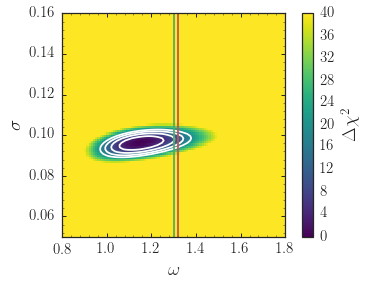

In [160]:
figsize(6,4)
bovy_plot.bovy_dens2d(-2.*(lnL-numpy.amax(lnL)).T,origin='lower',
                      xrange=[omegas[0],omegas[-1]],
                      yrange=[sigmas[0],sigmas[-1]],
                      xlabel=r'$\omega$',ylabel=r'$\sigma$',
                      zlabel=r'$\Delta\chi^2$',
                      colorbar=True,cmap='viridis',vmax=40.,
                      contours=True,levels=numpy.arange(5)*5.,cntrcolors='w',
                      interpolation='nearest')
axvline(omega_true,color=sns.color_palette()[1])
axvline((omega_out[-1]),color=sns.color_palette()[2])
print("Best fit: (omega,sigma) = (%.3f,%.3f)"\
          %(omegas[numpy.unravel_index(numpy.argmax(lnL),(len(omegas),len(sigmas)))[0]],
            sigmas[numpy.unravel_index(numpy.argmax(lnL),(len(omegas),len(sigmas)))[1]]))
tp= numpy.exp(lnL)
tp/= numpy.sum(tp)
print("Mean: (omega,sigma) = (%.4f,%.4f)"\
          %(numpy.sum(numpy.atleast_2d(omegas).T*tp),
            numpy.sum(numpy.atleast_2d(sigmas)*tp)))
print("errors: (omega,sigma) = (%.4f,%.4f)"\
          %(numpy.sqrt(numpy.sum(numpy.atleast_2d(omegas).T**2.*tp)-numpy.sum(numpy.atleast_2d(omegas).T*tp)**2.),
            numpy.sqrt(numpy.sum(numpy.atleast_2d(sigmas)**2.*tp)-numpy.sum(numpy.atleast_2d(sigmas)*tp)**2.)))
print("Correlation: %.2f" 
      % ((numpy.sum((numpy.atleast_2d(omegas).T*numpy.atleast_2d(sigmas)*tp))\
                   -numpy.sum(numpy.atleast_2d(omegas).T*tp)*numpy.sum(numpy.atleast_2d(sigmas)*tp))\
         /numpy.sqrt(numpy.sum(numpy.atleast_2d(omegas).T**2.*tp)-numpy.sum(numpy.atleast_2d(omegas).T*tp)**2.)\
         /numpy.sqrt(numpy.sum(numpy.atleast_2d(sigmas)**2.*tp)-numpy.sum(numpy.atleast_2d(sigmas)*tp)**2.)))

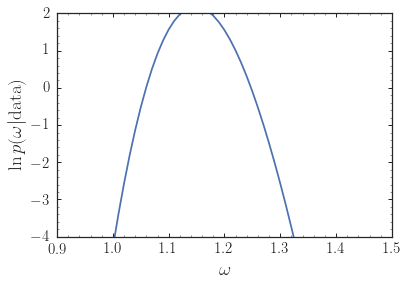

In [161]:
figsize(6,4)
ys= numpy.sum(numpy.exp(lnL),axis=1)
ys/= numpy.sum(ys)*(omegas[1]-omegas[0])
bovy_plot.bovy_plot(omegas,numpy.log(ys),
                    xrange=[0.9,1.5],
                    yrange=[-4.,2.],
                   xlabel=r'$\omega$',
                   ylabel=r'$\ln p(\omega|\mathrm{data})$')

What if we followed the standard procedure and computed the best-fit weights distribution for each $\omega$? This is shown in blue and compared to the result from assuming an isothermal DF above (green). The best-fit M2M value is in red.

In [163]:
omegas_opt= numpy.linspace(1.1,1.5,11)
nstep_opt= 100000
Qs= numpy.zeros_like(omegas_opt)
use_v2=True
for ii,omega_m2m in tqdm.tqdm(enumerate(omegas_opt),total=len(omegas_opt)):
    sigma_init= 0.2
    E_m2m= numpy.random.exponential(scale=sigma_init**2.,size=n_m2m)
    phi_m2m_omega= numpy.random.uniform(size=n_m2m)*2.*numpy.pi
    A_m2m_omega= numpy.sqrt(2.*E_m2m)/omega_m2m
    w_init= numpy.ones(n_m2m)/n_m2m
    z_m2m= A_m2m_omega*numpy.cos(phi_m2m_omega)
    vz_m2m= -omega_m2m*A_m2m_omega*numpy.sin(phi_m2m_omega)
    w_out,Q= hom2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_true,
                           z_obs,dens_obs,dens_obs_noise,
                           v2_obs,v2_obs_noise,use_v2=use_v2,
                           nstep=nstep_opt,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                           smooth=smooth,st96smooth=st96smooth)
    Qs[ii]= numpy.sum(numpy.median(Q[-100:-1],axis=0))

100%|██████████| 11/11 [19:12<00:00, 104.27s/it]


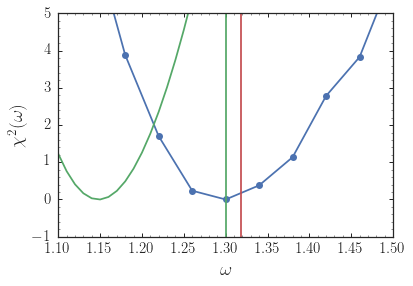

In [164]:
figsize(6,4)
bovy_plot.bovy_plot(omegas_opt,Qs-numpy.nanmin(Qs),
                    'o-',semilogy=False,yrange=[-1.,5.],
                   xlabel=r'$\omega$',ylabel=r'$\chi^2(\omega)$')
axvline(omega_true,color=sns.color_palette()[1])
axvline(omega_out[-1],color=sns.color_palette()[2])
plot(omegas,-2.*(numpy.log(ys)-numpy.nanmax(numpy.log(ys))))

In [165]:
Qys= numpy.exp(-0.5*Qs)
Qys/= numpy.sum(Qys)
print("Standard result: mean, unc.:",
      numpy.sum(omegas_opt*Qys),
      numpy.sqrt(numpy.sum(omegas_opt**2.*Qys)-numpy.sum(omegas_opt*Qys)**2.))

('Standard result: mean, unc.:', 1.3114180712431258, 0.06910340523722093)


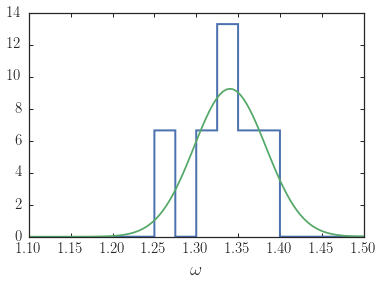

In [166]:
figsize(6,4)
_= hist(omega_sam,range=[1.2,1.5],bins=12,histtype='step',lw=2.,normed=True)
xlabel(r'$\omega$')
momega, somega= numpy.mean(omega_sam), numpy.std(omega_sam)
xs= numpy.linspace(1.1,1.5,101)
ys= numpy.exp(-0.5*(xs-momega)**2./somega**2.)
ys/= numpy.sum(ys)*(xs[1]-xs[0])
plot(xs,ys)

## Fitting for both $z_\odot$ and $\omega$

In [167]:
n_m2m= 1000
omega_m2m= omega_true-0.5
sigma_init= 0.2
E_m2m= numpy.random.exponential(scale=sigma_init**2.,size=n_m2m)
phi_m2m_omega= numpy.random.uniform(size=n_m2m)*2.*numpy.pi
A_m2m_omega= numpy.sqrt(2.*E_m2m)/omega_m2m
w_init= numpy.ones(n_m2m)/n_m2m
z_m2m= A_m2m_omega*numpy.cos(phi_m2m_omega)
vz_m2m= -omega_m2m*A_m2m_omega*numpy.sin(phi_m2m_omega)

In [168]:
reload(hom2m)

<module 'hom2m' from 'hom2m.pyc'>

In [169]:
step= numpy.pi/3.*10.**-2.
nstep= 300000
# eps= [10.**-3.5,10.**-6.,10.**-6.]
eps= [10.**-3.5,10.**-6.,10.**-3.5]
smooth= None#1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.075
#omega_m2m= set in previous cell
zsun_m2m= -0.05
fit_zsun= True
fit_omega= True
use_v2= True
skipomega= 10
prior= 'entropy'
w_out,zsun_out,omega_out,z_final, vz_final, Q,wevol,windx=\
        hom2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
        z_obs,dens_obs,dens_obs_noise,
        v2_obs,v2_obs_noise,use_v2=use_v2,
        nstep=nstep,step=step,mu=mu,eps=eps,
        h_m2m=h_m2m,prior=prior,
        smooth=smooth,st96smooth=st96smooth,
        output_wevolution=10,
        fit_omega=fit_omega,skipomega=skipomega,
        fit_zsun=fit_zsun)

('Velocity dispersions: mock, fit', 0.099928616243094737, 0.094080349063821886)
('omega: best-fit', 1.1802779796957683)
('zsun: best-fit', 0.061739622542087778)


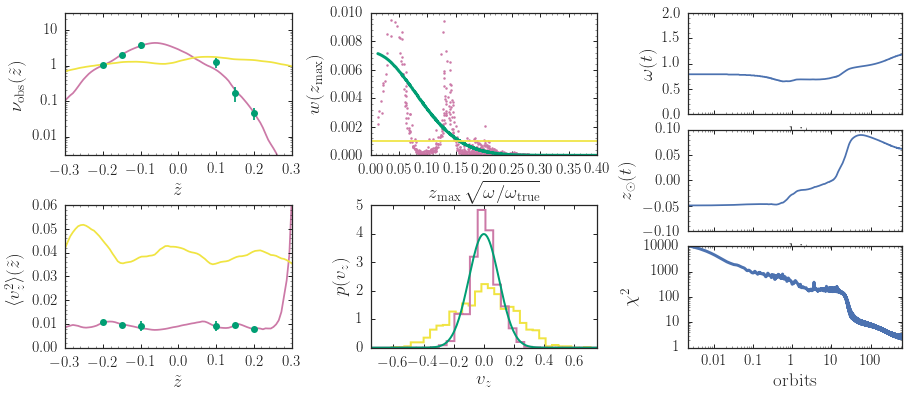

In [170]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_final,vz_final,omega_out[-1])
A_init, phi_init= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_out= numpy.linspace(-0.35,0.35,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
dens_final= hom2m.compute_dens(z_final,zsun_out[-1],z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_final,vz_final,zsun_out[-1],z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
gs= gridspec.GridSpec(2,3,hspace=0.35,wspace=0.35)
gs2= gridspec.GridSpec(3,3,hspace=0.15,wspace=0.45)
subplot(gs[0])
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.3,0.3],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(gs[3])
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[-.3,0.3],yrange=[0.0,.06],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(gs[1])
bovy_plot.bovy_plot(A_m2m*numpy.sqrt(omega_out[-1]/1.3),w_out,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}\,\sqrt{\omega/\omega_{\mathrm{true}}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,10./len(w_out)],xrange=[0.,0.4],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_init[sindx]*omega_m2m)**2./2./sigma_init**2.-(A_m2m[sindx]*omega_true)**2./2./sigma_true**2.)
w_expect/= numpy.sum(w_expect)
plot(A_m2m[sindx]*numpy.sqrt(omega_out[-1]/1.3),w_expect,lw=3.,color=constraint_color)
sindx= numpy.argsort(A_m2m_sam*numpy.sqrt(omega_sam[0])) # might have changed due to pickling
axhline(1./len(z_m2m),color=init_color,)
subplot(gs[4])
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(-0.75,0.75,201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_final,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-0.75,0.75)
ylim(0.,5.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_final-numpy.sum(w_out*vz_final)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(gs2[0,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,2.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
print("omega: best-fit",omega_out[-1])
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[1,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,zsun_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[-0.1,0.1],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot(t)$',gcf=True)
print("zsun: best-fit",zsun_out[-1])
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[2,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
#tight_layout()

And the MCMC sampling:

In [171]:
savefilename= 'full_data.sav' 
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
    w_out,z_final,vz_final,omega_out,zsun_out,z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise,w_init= out
else:
    save_pickles(savefilename,w_out,z_final,vz_final,omega_out,zsun_out,
                 z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise,w_init)

In [172]:
step_sam= numpy.pi/3.*10.**-2.
nstep_sam= 100000
eps_sam= eps[0]
nsamples= 100
fit_omega= True
sig_omega= 0.2 # proposal step
nstep_omega= 1000
nmh_omega= 20
fit_zsun= True
sig_zsun= 0.01
nstep_zsun= 500
nmh_zsun= 20
s_low, s_high= 16,-16
use_v2=True
# for test
nsamples=6
s_low, s_high= 1,4
savefilename= 'full_sam.sav'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
else:
    out= hom2m.sample_m2m(nsamples,w_out,z_final,vz_final,omega_out[-1],zsun_out[-1],
                          z_obs,dens_obs,dens_obs_noise,
                          densv2_obs=v2_obs,densv2_obs_noise=v2_obs_noise,use_v2=use_v2,
                          nstep=nstep_sam,step=step_sam,eps=eps_sam,
                          mu=mu,h_m2m=h_m2m,prior=prior,w_prior=w_init,
                          smooth=smooth,st96smooth=st96smooth,
                          fit_omega=fit_omega,sig_omega=sig_omega,nstep_omega=nstep_omega,nmh_omega=nmh_omega,
                          fit_zsun=fit_zsun,sig_zsun=sig_zsun,nstep_zsun=nstep_zsun,nmh_zsun=nmh_zsun)
    save_pickles(savefilename,*out)
w_sam,zsun_sam,omega_sam,Q_sam,z_sam,vz_sam= out

100%|██████████| 6/6 [16:08<00:00, 161.28s/it]

MH acceptance ratio for zsun was 0.37
MH acceptance ratio for omega was 0.27


The chain:

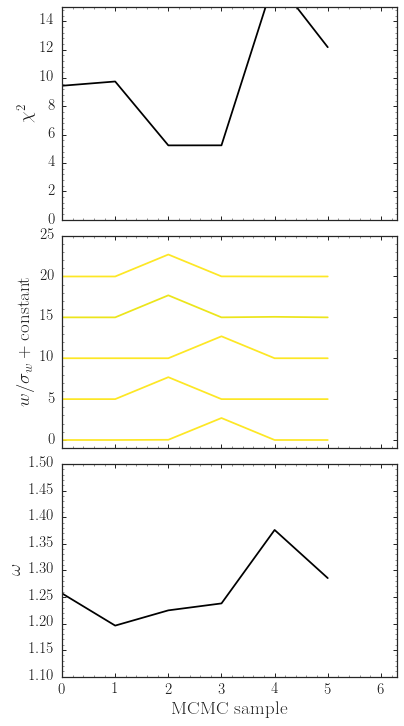

In [173]:
A_m2m_sam, _= hom2m.zvz_to_Aphi(z_sam[0],vz_sam[0],omega_sam[0]) # Make sure to lign up A_m2m and sampling orbits
figsize(6,12)
gs= gridspec.GridSpec(3,1,hspace=0.075,wspace=0.0)
subplot(gs[0])
bovy_plot.bovy_plot(numpy.sum(Q_sam,axis=1),gcf=True,color='k',
                   ylabel=r'$\chi^2$',
                   xrange=[0.,nsamples*1.05],
                   yrange=[0.,15.])
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs[1])
nran= 5
rndindx= numpy.random.permutation(len(w_sam[0]))[:nran-1]
# Add a weight near in A_m2m to the weight with the 2nd largest A_m2m
medA= A_m2m_sam[rndindx][numpy.argsort(A_m2m_sam[rndindx])[-3]]
newi= numpy.argmin(numpy.fabs(A_m2m_sam-medA+0.005))
rndindx= list(rndindx)
rndindx.append(newi)
rndindx= numpy.array(rndindx,dtype='int')
sindx= numpy.argsort(numpy.argsort(numpy.nanmean(w_sam[:,rndindx],axis=0)))
for ii,jj in enumerate(rndindx):
    bovy_plot.bovy_plot(w_sam[:,jj]/numpy.nanstd(w_sam[:,jj])+5*sindx[ii],'-',
                        color=cm.viridis(A_m2m_sam[jj]*numpy.sqrt(omega_out[0]/1.3)/0.3),
                        xrange=[0.,nsamples*1.05],
                        yrange=[-1,25],
                        ylabel=r'$w/\sigma_w+\mathrm{constant}$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs[2])
bovy_plot.bovy_plot(omega_sam,gcf=True,color='k',
                    xlabel=r'$\mathrm{MCMC\ sample}$',
                    ylabel=r'$\omega$',
                    xrange=[0.,nsamples*1.05],
                    yrange=[1.1,1.5])

The summary plot:

('Velocity dispersions: mock, fit, mean of samples (unc.)', 0.099928616243094737, 0.094080349063821886, 0.09855663749482467, 0.0047971674123713426)
('omega: best-fit, mean of samples unc.)', 1.1802779796957683, 1.2628661853457068, 0.057594644839853514)
('zsun: best-fit, mean of samples unc.)', 0.061739622542087778, 0.058444202832386327, 0.0025092735936219726)


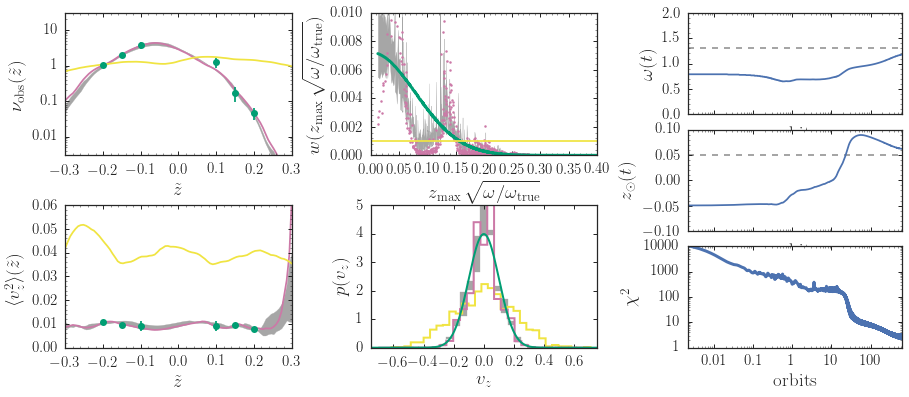

In [174]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_final,vz_final,omega_out[-1])
A_init, phi_init= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_out= numpy.linspace(-0.35,0.35,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
dens_final= hom2m.compute_dens(z_final,zsun_out[-1],z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_final,vz_final,zsun_out[-1],z_out,h_m2m,w=w_out)
# density and densv2 for samples
dens_final_sam= numpy.empty((nsamples,len(dens_final)))
v2_final_sam= numpy.empty((nsamples,len(dens_final)))
vz_hist= numpy.empty((nsamples,31))
sigvz= numpy.empty((nsamples))
for ii in range(nsamples):
    dens_final_sam[ii]= hom2m.compute_dens(z_sam[ii],zsun_sam[ii],z_out,h_m2m,w=w_sam[ii])
    v2_final_sam[ii]= hom2m.compute_v2(z_sam[ii],vz_sam[ii],zsun_sam[ii],z_out,h_m2m,w=w_sam[ii])
    vz_hist[ii], _= numpy.histogram(vz_sam[ii],weights=w_sam[ii],normed=True,bins=31,range=[-0.7,0.7])
    sigvz[ii]= numpy.sqrt(numpy.nansum(w_sam[ii]*(vz_sam[ii]\
                            -numpy.nansum(w_sam[ii]*vz_sam[ii])/numpy.nansum(w_sam[ii]))**2.)/numpy.nansum(w_sam[ii]))
dens_final_sam_sorted= numpy.sort(dens_final_sam,axis=0)
v2_final_sam_sorted= numpy.sort(v2_final_sam,axis=0)
w_sam_sorted= numpy.sort(w_sam,axis=0)
vz_hist_sorted= numpy.sort(vz_hist,axis=0)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
gs= gridspec.GridSpec(2,3,hspace=0.35,wspace=0.35)
gs2= gridspec.GridSpec(3,3,hspace=0.15,wspace=0.45)
subplot(gs[0])
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.3,0.3],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
fill_between(z_out,dens_final_sam_sorted[s_low],dens_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(gs[3])
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[-.3,0.3],yrange=[0.0,.06],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
fill_between(z_out,v2_final_sam_sorted[s_low],v2_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                 lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(gs[1])
bovy_plot.bovy_plot(A_m2m*numpy.sqrt(omega_out[-1]/1.3),w_out,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}\,\sqrt{\omega/\omega_{\mathrm{true}}}$',
                    ylabel=r'$w(z_{\mathrm{max}}\,\sqrt{\omega/\omega_{\mathrm{true}}})$',
                   yrange=[0.,10./len(w_out)],xrange=[0.,0.4],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_init[sindx]*omega_m2m)**2./2./sigma_init**2.-(A_m2m[sindx]*omega_true)**2./2./sigma_true**2.)
w_expect/= numpy.sum(w_expect)
plot(A_m2m[sindx]*numpy.sqrt(omega_out[-1]/1.3),w_expect,lw=3.,color=constraint_color)
sindx= numpy.argsort(A_m2m_sam*numpy.sqrt(omega_sam[0])) # might have changed due to pickling
fill_between(A_m2m_sam[sindx]*numpy.sqrt(omega_sam[0]/1.3),
             w_sam_sorted[s_low][sindx],
             w_sam_sorted[s_high][sindx],color='0.65',zorder=0)
axhline(1./len(z_m2m),color=init_color,)
subplot(gs[4])
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(-0.75,0.75,201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
h,e,p= hist(vz_final,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color,
            range=[-0.7,0.7])
fill_between(0.5*(e+numpy.roll(e,1))[1:],vz_hist_sorted[s_low],vz_hist_sorted[s_high],color='0.65',zorder=0,step='mid')
xlim(-0.75,0.75)
ylim(0.,5.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit, mean of samples (unc.)",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_final-numpy.sum(w_out*vz_final)/numpy.sum(w_out))**2.)/numpy.sum(w_out)),
      numpy.nanmean(sigvz),
      numpy.nanstd(sigvz))
print("omega: best-fit, mean of samples unc.)",omega_out[-1],numpy.mean(omega_sam),numpy.std(omega_sam))
subplot(gs2[0,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,2.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
axhline(omega_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[1,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,zsun_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[-0.1,0.1],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot(t)$',gcf=True)
axhline(zsun_true,ls='--',color='0.65',lw=2.,zorder=0)
print("zsun: best-fit, mean of samples unc.)",zsun_out[-1],numpy.mean(zsun_sam),numpy.std(zsun_sam))
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[2,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-hom2m','full_m2m.pdf'),
                bbox_inches='tight')